# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part C 

## Implement Custom Resnet + Layer Normalization

In [3]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([out_channels, size, size])
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([out_channels, size, size])

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.ln2(x)
        x += shortcut
        x = self.elu(x)
        return x

class CustomResNet_LN(nn.Module):
    def __init__(self):
        super(CustomResNet_LN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([32, 32, 32])
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([64, 32, 32])
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64, 16)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.ln3 = nn.LayerNorm([128, 16, 16])
        self.elu3 = nn.ELU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.ln4 = nn.LayerNorm([256, 8, 8])
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256, 4)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.ln5 = nn.LayerNorm(256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.ln2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.ln3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.ln4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.ln5(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

## Load Dataset

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [6]:
# Model, optimizer, and scheduler
model = CustomResNet_LN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [7]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet_LN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln1): LayerNorm((32, 32, 32), eps=1e-05, elementwise_affine=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln2): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ln1): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ln2): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
  )
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln3): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
  (elu3): ELU(alpha=1.0)
  (maxpool2): Ma

In [8]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [9]:
for epoch in range(1, 101):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 2.1351, Train Accuracy: 32.42%, Val Loss: 2.0535, Val Accuracy: 40.42%
Epoch: 2, Train Loss: 2.0061, Train Accuracy: 45.93%, Val Loss: 1.9830, Val Accuracy: 48.78%
Epoch: 3, Train Loss: 1.9429, Train Accuracy: 52.48%, Val Loss: 1.9273, Val Accuracy: 54.14%
Epoch: 4, Train Loss: 1.8892, Train Accuracy: 57.91%, Val Loss: 1.9091, Val Accuracy: 55.28%
Epoch: 5, Train Loss: 1.8546, Train Accuracy: 61.21%, Val Loss: 1.8197, Val Accuracy: 64.90%
Epoch: 6, Train Loss: 1.8185, Train Accuracy: 65.03%, Val Loss: 1.8550, Val Accuracy: 61.22%
Epoch: 7, Train Loss: 1.8065, Train Accuracy: 66.08%, Val Loss: 1.8081, Val Accuracy: 65.46%
Epoch: 8, Train Loss: 1.7778, Train Accuracy: 68.92%, Val Loss: 1.7751, Val Accuracy: 68.92%
Epoch: 9, Train Loss: 1.7716, Train Accuracy: 69.47%, Val Loss: 1.7752, Val Accuracy: 68.70%
Epoch: 10, Train Loss: 1.7548, Train Accuracy: 71.11%, Val Loss: 1.7550, Val Accuracy: 71.00%
Epoch: 11, Train Loss: 1.7495, Train Accuracy: 71.62%, Val Loss: 1.76

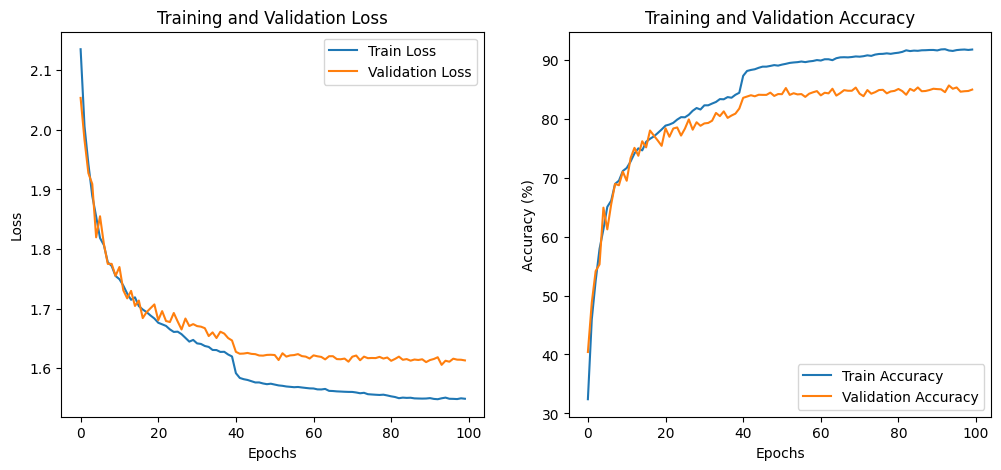

Best Validation Accuracy: 85.62%
Test Accuracy of the final model: 85.24%


In [10]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights_LN.pth')

# Layer Wise analyse , Part A

In [ ]:
# download Pretrained Weight of model
import gdown
id = "1DMolTIP0BuQAD0xzegt31_VojQLQ5SZq"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [2]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [3]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([out_channels, size, size])
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([out_channels, size, size])

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.ln2(x)
        x += shortcut
        x = self.elu(x)
        return x

class CustomResNet_LN(nn.Module):
    def __init__(self):
        super(CustomResNet_LN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([32, 32, 32])
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([64, 32, 32])
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64, 16)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.ln3 = nn.LayerNorm([128, 16, 16])
        self.elu3 = nn.ELU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.ln4 = nn.LayerNorm([256, 8, 8])
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256, 4)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.ln5 = nn.LayerNorm(256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.ln2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.ln3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.ln4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.ln5(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.2 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Instantiate and load the model
model = CustomResNet_LN()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights_LN.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet_LN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln1): LayerNorm((32, 32, 32), eps=1e-05, elementwise_affine=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln2): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ln1): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ln2): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
  )
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln3): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
  (elu3): ELU(alpha=1.0)
  (maxpool2): Ma

In [7]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {''}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [9]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 36/36 [00:00<00:00, 68.14it/s]


### Calc SI

In [10]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 368.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7381.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7241.55it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7519.37it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8044.31it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7637.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7704.45it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7592.87it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7426.18it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7410.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8022.77it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7016.23it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7503.23it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6815.57it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7371.36it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7952.79it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6935.03it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7592.87it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7901.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6824.45it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7524.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7434.07it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7587.38it/s]


In [11]:
si_layer_train

[('conv1', 0.23288889229297638),
 ('ln1', 0.28566667437553406),
 ('elu1', 0.2814444601535797),
 ('conv2', 0.2516666650772095),
 ('ln2', 0.34333333373069763),
 ('elu2', 0.3512222170829773),
 ('maxpool1', 0.4519999921321869),
 ('resblock1', 0.5446666479110718),
 ('conv3', 0.5715555548667908),
 ('ln3', 0.5964444279670715),
 ('elu3', 0.5905555486679077),
 ('maxpool2', 0.6180000305175781),
 ('conv4', 0.6485555768013),
 ('maxpool3', 0.6707777976989746),
 ('ln4', 0.6471111178398132),
 ('elu4', 0.6500000357627869),
 ('resblock2', 0.7488889098167419),
 ('avgpool', 0.8009999990463257),
 ('flatten', 0.8009999990463257),
 ('fc1', 0.8604444265365601),
 ('ln5', 0.8885555863380432),
 ('fc2', 0.8718888759613037),
 ('softmax', 0.8825555443763733)]

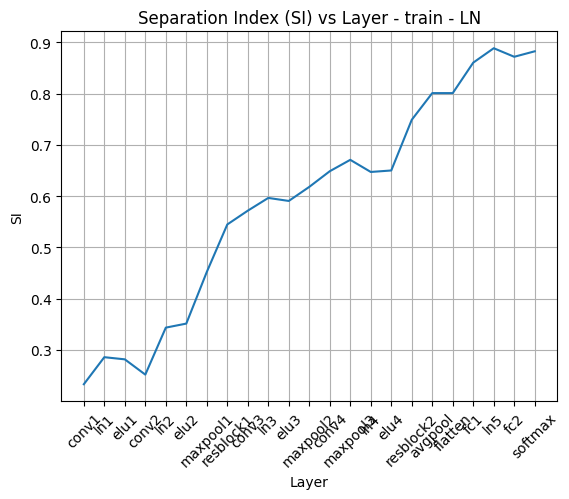

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - train - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [13]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 752.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4919.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4567.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4133.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4151.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4287.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3219.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3287.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4960.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4551.11it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4657.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4095.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3201.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4143.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3381.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3250.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4264.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1791.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3003.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3416.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3381.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4229.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4431.85it/s]


[('conv1', 0.3491111099720001), ('ln1', 0.3575555682182312), ('elu1', 0.3607777953147888), ('conv2', 0.37888890504837036), ('ln2', 0.38288888335227966), ('elu2', 0.3968888819217682), ('maxpool1', 0.44966667890548706), ('resblock1', 0.5547778010368347), ('conv3', 0.5753333568572998), ('ln3', 0.5740000009536743), ('elu3', 0.5825555324554443), ('maxpool2', 0.5983333587646484), ('conv4', 0.6256666779518127), ('maxpool3', 0.6557778120040894), ('ln4', 0.6261110901832581), ('elu4', 0.636555552482605), ('resblock2', 0.7725555896759033), ('avgpool', 0.8455555438995361), ('flatten', 0.8455555438995361), ('fc1', 0.91311115026474), ('ln5', 0.9184444546699524), ('fc2', 0.9034444689750671), ('softmax', 0.9236666560173035)]


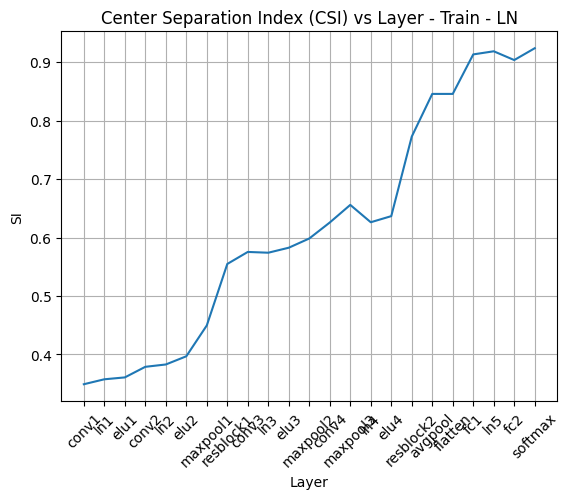

In [14]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Train - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 23.08it/s]


### Calc SI

In [9]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 216.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4789.84it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4532.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4826.59it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5289.16it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5518.82it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5049.32it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5180.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5102.56it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5264.82it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5365.85it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5384.22it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5253.83it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4871.43it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5152.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5051.35it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5877.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 6034.97it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5466.08it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 1548.67it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 2455.68it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 1596.82it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 1580.17it/s]


In [10]:
si_layer_val

[('conv1', 0.21879999339580536),
 ('ln1', 0.27699998021125793),
 ('elu1', 0.2669999897480011),
 ('conv2', 0.23479999601840973),
 ('ln2', 0.3107999861240387),
 ('elu2', 0.3181999921798706),
 ('maxpool1', 0.4105999767780304),
 ('resblock1', 0.4973999857902527),
 ('conv3', 0.5263999700546265),
 ('ln3', 0.5551999807357788),
 ('elu3', 0.5483999848365784),
 ('maxpool2', 0.5879999995231628),
 ('conv4', 0.6157999634742737),
 ('maxpool3', 0.6421999931335449),
 ('ln4', 0.6110000014305115),
 ('elu4', 0.6129999756813049),
 ('resblock2', 0.7235999703407288),
 ('avgpool', 0.7906000018119812),
 ('flatten', 0.7906000018119812),
 ('fc1', 0.8571999669075012),
 ('ln5', 0.8841999769210815),
 ('fc2', 0.8693999648094177),
 ('softmax', 0.7853999733924866)]

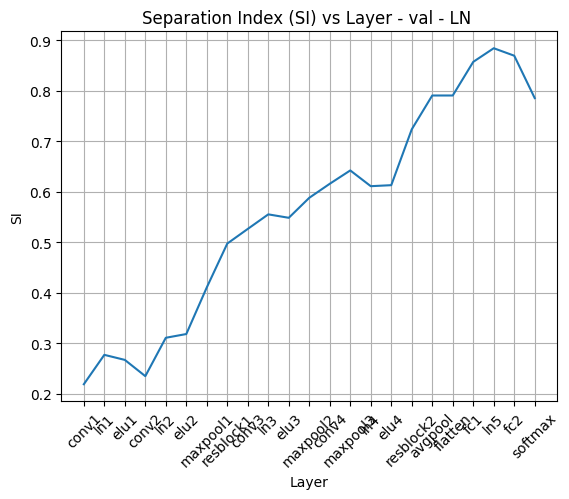

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - val - LN ')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [12]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 429.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3382.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3113.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2971.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3376.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3321.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3069.75it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3337.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3494.28it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3253.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3320.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2983.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3184.74it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3024.01it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2742.57it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3246.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3101.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1796.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2454.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2353.71it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2362.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2828.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3284.50it/s]


[('conv1', 0.35359999537467957), ('ln1', 0.36820000410079956), ('elu1', 0.3755999803543091), ('conv2', 0.3921999931335449), ('ln2', 0.39479997754096985), ('elu2', 0.4039999842643738), ('maxpool1', 0.4575999975204468), ('resblock1', 0.5687999725341797), ('conv3', 0.5839999914169312), ('ln3', 0.5857999920845032), ('elu3', 0.5929999947547913), ('maxpool2', 0.6115999817848206), ('conv4', 0.6349999904632568), ('maxpool3', 0.6643999814987183), ('ln4', 0.6380000114440918), ('elu4', 0.642799973487854), ('resblock2', 0.7777999639511108), ('avgpool', 0.8333999514579773), ('flatten', 0.8333999514579773), ('fc1', 0.9111999869346619), ('ln5', 0.9138000011444092), ('fc2', 0.9016000032424927), ('softmax', 0.9210000038146973)]


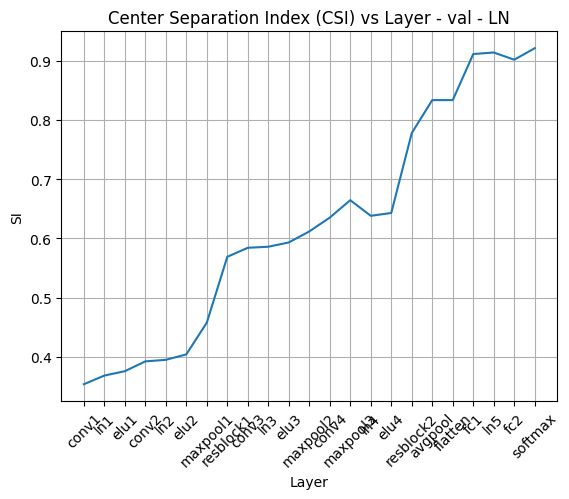

In [13]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - val - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 27.29it/s]


### Calc SI

In [9]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 362.01it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7261.61it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7468.49it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8050.49it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7394.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7744.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7645.47it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7423.55it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7755.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7928.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7735.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7415.67it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7617.70it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7023.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6992.84it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7772.99it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7335.26it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7712.95it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7513.98it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8134.80it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7264.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7484.48it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7684.69it/s]


In [10]:
si_layer_test

[('conv1', 0.23099999129772186),
 ('ln1', 0.299699991941452),
 ('elu1', 0.29350000619888306),
 ('conv2', 0.2685000002384186),
 ('ln2', 0.36739999055862427),
 ('elu2', 0.36579999327659607),
 ('maxpool1', 0.4578000009059906),
 ('resblock1', 0.554099977016449),
 ('conv3', 0.5766000151634216),
 ('ln3', 0.5928999781608582),
 ('elu3', 0.590399980545044),
 ('maxpool2', 0.618399977684021),
 ('conv4', 0.6495999693870544),
 ('maxpool3', 0.6740999817848206),
 ('ln4', 0.6500999927520752),
 ('elu4', 0.6513999700546265),
 ('resblock2', 0.7339999675750732),
 ('avgpool', 0.7622999548912048),
 ('flatten', 0.7622999548912048),
 ('fc1', 0.7806999683380127),
 ('ln5', 0.8167999982833862),
 ('fc2', 0.7879999876022339),
 ('softmax', 0.7595999836921692)]

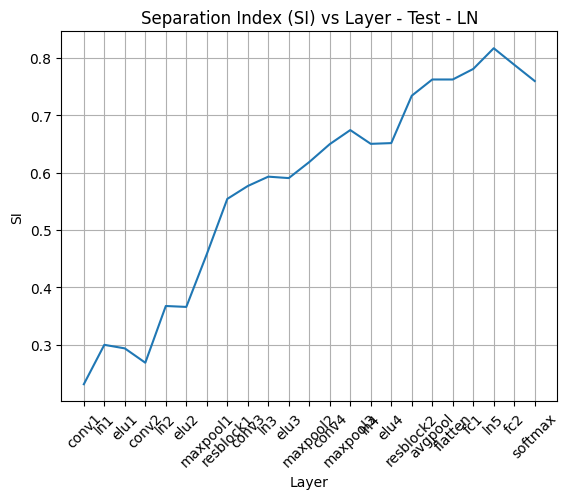

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Test - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [12]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 730.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4395.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4279.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4201.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4479.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4433.73it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3256.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3264.05it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4610.14it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4561.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4538.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4283.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3267.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4149.49it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3345.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4075.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4384.60it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4165.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4422.51it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4522.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4180.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4689.52it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4012.15it/s]


[('conv1', 0.3447999954223633), ('ln1', 0.3572999835014343), ('elu1', 0.3594000041484833), ('conv2', 0.38169997930526733), ('ln2', 0.3868999779224396), ('elu2', 0.3983999788761139), ('maxpool1', 0.4486999809741974), ('resblock1', 0.5444999933242798), ('conv3', 0.5670999884605408), ('ln3', 0.5669999718666077), ('elu3', 0.5748000144958496), ('maxpool2', 0.5911999940872192), ('conv4', 0.614300012588501), ('maxpool3', 0.6432999968528748), ('ln4', 0.6191999912261963), ('elu4', 0.6251999735832214), ('resblock2', 0.7429999709129333), ('avgpool', 0.7907999753952026), ('flatten', 0.7907999753952026), ('fc1', 0.8460999727249146), ('ln5', 0.8504999876022339), ('fc2', 0.8353999853134155), ('softmax', 0.8522999882698059)]


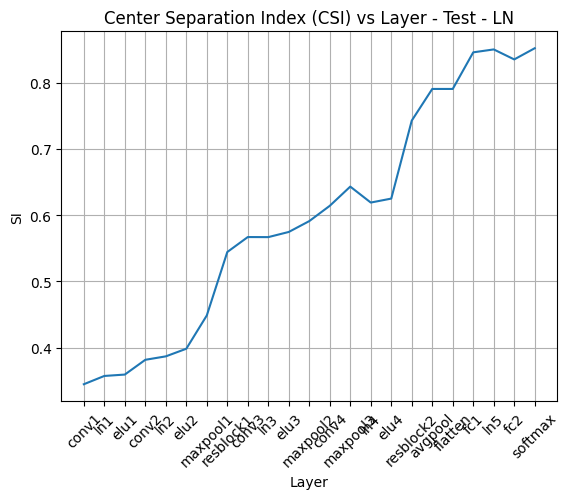

In [13]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Test - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()